<a href="https://colab.research.google.com/github/kridtapon/WFO-New-Cloud-Optimized-Momentum/blob/main/WFO_New_Cloud_Optimized_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.6 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
<ipython-input-8-44af112ad9f4>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-8-44af112ad9f4>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-8-44af112ad9f4>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in


Walk-Forward Optimization Results:
   Year   Best_Params  Test_Return
0  2020  (10, 27, 40)     0.275113
1  2021  (11, 27, 40)     0.183396
2  2022  (15, 24, 48)    -0.058177
3  2023  (15, 24, 51)     1.834748
4  2024  (15, 24, 48)     0.318983
5  2025  (18, 24, 55)     0.000000
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           544006.776068
Total Return [%]                       444.006776
Benchmark Return [%]                   180.172876
Max Gross Exposure [%]                      100.0
Total Fees Paid                       3433.229015
Max Drawdown [%]                        26.130027
Max Drawdown Duration                       345.0
Total Trades                                    8
Total Closed Trades                             7
Total Open Trades                               1
Open Trade PnL     

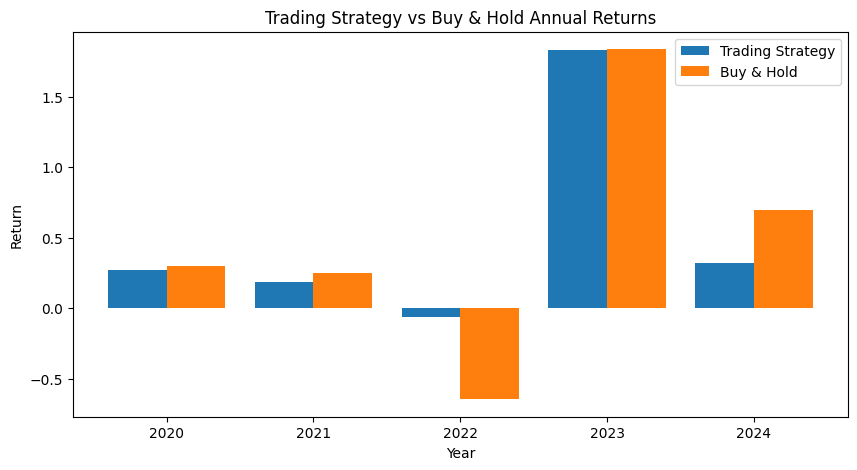

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate Ichimoku Cloud components
def calculate_ichimoku(df, tenkan_period=9, kijun_period=26, senkou_span_b_period=52):
    high_9 = df['High'].rolling(window=tenkan_period).max()
    low_9 = df['Low'].rolling(window=tenkan_period).min()
    df['Tenkan-sen'] = (high_9 + low_9) / 2

    high_26 = df['High'].rolling(window=kijun_period).max()
    low_26 = df['Low'].rolling(window=kijun_period).min()
    df['Kijun-sen'] = (high_26 + low_26) / 2

    df['Senkou Span A'] = ((df['Tenkan-sen'] + df['Kijun-sen']) / 2).shift(kijun_period)

    high_52 = df['High'].rolling(window=senkou_span_b_period).max()
    low_52 = df['Low'].rolling(window=senkou_span_b_period).min()
    df['Senkou Span B'] = ((high_52 + low_52) / 2).shift(kijun_period)

    df['Chikou Span'] = df['Close'].shift(-kijun_period)

    return df

# Walk-forward optimization with Ichimoku Cloud
def walk_forward_optimization_ichimoku(df, start_year, end_year):
    results = []

    # Define dynamic ranges for Ichimoku periods
    tenkan_period_range = range(7, 21)  # Range for Tenkan-sen periods
    kijun_period_range = range(20, 51)  # Range for Kijun-sen periods
    senkou_span_b_period_range = range(40, 61)  # Range for Senkou Span B periods

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of Ichimoku parameters
        for params in itertools.product(tenkan_period_range, kijun_period_range, senkou_span_b_period_range):
            tenkan_period, kijun_period, senkou_span_b_period = params

            # Calculate Ichimoku indicators on the training data
            train_data = calculate_ichimoku(train_data, tenkan_period, kijun_period, senkou_span_b_period)

            # Generate entry and exit signals based on Ichimoku Cloud
            entries = (train_data['Close'] > train_data['Senkou Span A']) & (train_data['Close'] > train_data['Senkou Span B']) & (train_data['Tenkan-sen'] > train_data['Kijun-sen'])
            exits = (train_data['Close'] < train_data['Senkou Span A']) & (train_data['Close'] < train_data['Senkou Span B']) & (train_data['Tenkan-sen'] < train_data['Kijun-sen'])

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (tenkan_period, kijun_period, senkou_span_b_period)

        # Test with the best parameters on the test data
        # Extend the data range to include the previous year for indicator calculation
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply Ichimoku indicators
        yearly_data = calculate_ichimoku(yearly_data, best_params[0], best_params[1], best_params[2])

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = (yearly_data['Close'] > yearly_data['Senkou Span A']) & (yearly_data['Close'] > yearly_data['Senkou Span B']) & (yearly_data['Tenkan-sen'] > yearly_data['Kijun-sen'])
        exits = (yearly_data['Close'] < yearly_data['Senkou Span A']) & (yearly_data['Close'] < yearly_data['Senkou Span B']) & (yearly_data['Tenkan-sen'] < yearly_data['Kijun-sen'])

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'META'  # NFLX META FICO FOX FOXA TPL
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization_ichimoku(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply Ichimoku indicators
    yearly_data = calculate_ichimoku(yearly_data, params[0], params[1], params[2])

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    # Define entry/exit conditions
    entries = (yearly_data['Close'] > yearly_data['Senkou Span A']) & \
              (yearly_data['Close'] > yearly_data['Senkou Span B']) & \
              (yearly_data['Tenkan-sen'] > yearly_data['Kijun-sen'])
    exits = (yearly_data['Close'] < yearly_data['Senkou Span A']) & \
            (yearly_data['Close'] < yearly_data['Senkou Span B']) & \
            (yearly_data['Tenkan-sen'] < yearly_data['Kijun-sen'])

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()

In [9]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,280172.876053
Total Return [%],180.172876
Benchmark Return [%],180.172876
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],76.736092
